In [1]:
import os
import hashlib
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    Ridge,
    LassoCV,
    RidgeCV,
    LogisticRegression,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor

In [2]:
RANDOM_STATE = 42

In [3]:
def hash_columns(columns):
    col_str = ",".join(sorted(columns))
    return hashlib.sha256(col_str.encode()).hexdigest()

In [4]:
def hash_series(series):
    series_str = ",".join(map(str, series.values))
    return hashlib.sha256(series_str.encode()).hexdigest()

In [5]:
def hash_data_frame(df):
    df_sorted = df.sort_index(axis=1).sort_values(by=list(df.columns))
    return hashlib.sha256(pd.util.hash_pandas_object(df_sorted, index=True).values).hexdigest()

In [6]:
def check_signature(expected, actual):
    # print(actual)
    try:
        assert actual == expected
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [7]:
def test_func(func, signature):
    df = pd.read_csv("manufacturing-test.csv")
    df = func(df)
    check_signature(signature, hash_data_frame(df))

In [8]:
def test_partition(func, train_X_signature, test_X_signature, train_y_signature, test_y_signature):
    df = pd.read_csv("manufacturing-test.csv")
    train_X, test_X, train_y, test_y = func(df)
    try:
        # print(hash_data_frame(train_X))
        # print(hash_data_frame(test_X))
        # print(hash_series(train_y))
        # print(hash_series(test_y))
        assert hash_data_frame(train_X) == train_X_signature
        assert hash_data_frame(test_X) == test_X_signature
        assert hash_series(train_y) == train_y_signature
        assert hash_series(test_y) == test_y_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [9]:
def test_normalize(func, train_X_signature, test_X_signature):
    df = pd.read_csv("manufacturing-test.csv")
    train_X, test_X = func(df[:80][["machine_temperature", "machine_vibration"]], df[80:100][["machine_temperature", "machine_vibration"]])
    try:
        # print(hash_data_frame(pd.DataFrame(train_X)))
        # print(hash_data_frame(pd.DataFrame(test_X)))
        assert hash_data_frame(pd.DataFrame(train_X)) == train_X_signature
        assert hash_data_frame(pd.DataFrame(test_X)) == test_X_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [10]:
def test_model(func, pred_y_signature):
    df = pd.read_csv("manufacturing-test.csv").dropna(axis=0)
    model = func(df[:2000][["lubrication_index", "machine_health_index"]], df[:2000]["fault_severity"])
    model = func(train_X, train_y)
    pred_y = model.predict(train_X)
    try:
        # print(hash_series(pd.Series(pred_y)))
        assert hash_series(pd.Series(pred_y)) == pred_y_signature
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [11]:
def test_evaluation(precision, recall, f1):
    try:
        assert precision > 0.70
        assert recall > 0.70
        assert f1 > 0.70
        print("✔ Test passed!")
    except AssertionError:
        print("✘ Test failed.")
        raise

In [12]:
df = pd.read_csv("manufacturing.csv")

In [13]:
df.head()

,device_info,sensor_packet,runtime_hours,lubrication_index,machine_health_index,operation_mode,plant_section,product_family,production_stage,fault_severity,certification_level,output_quality
0,LINE-8665,T:28.78 V:10.04 H:59.2,5.678161,5.032585,NaN,auto,South,Fam_02,Processing,No Fault,ISO9001,Medium
1,LINE-2610,T:19.28 V:2.55 H:67.2,6.784672,1.149299,0.123425,semi_auto,North,Fam_19,Assembly,NaN,ISO9001,Low
2,MCH-1237,T:23.88 V:8.46 H:54.0,1.266339,6.566656,3.184291,manual,West,Fam_05,Processing,Low,ISO9001,High
3,LINE-6758,T:23.22 V:8.22 H:45.4,6.254449,NaN,2.220018,auto,North,Fam_18,Init,No Fault,ISO9001,High
4,BOT-4288,T:25.68 V:3.90 H:41.2,5.328184,3.880788,1.363712,auto,South,Fam_04,Init,No Fault,ISO9001,Medium


In [14]:
### MANUALLY GRADED TASK
def calculate_descriptive_statistics(df):
    """
    Calculate the descriptive statistics for all numeric variables in the dataset.
    The statistics should include: count, mean, standard deviation, minimum,
    25th percentile, median, 75th percentile, and maximum.
    
    Return the result as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    return df.describe()
    ### END SOLUTION

In [15]:
calculate_descriptive_statistics(df)

,runtime_hours,lubrication_index,machine_health_index
count,9509.000000,9272.000000,9282.000000
mean,3.887883,4.079428,2.192250
std,1.958240,1.731052,0.842375
min,0.096352,0.989654,0.000000
25%,2.395671,2.884860,1.612753
50%,3.659388,3.764231,2.100314
75%,5.116152,4.870681,2.649859
max,11.886164,19.998966,10.000000


In [16]:
### MANUALLY GRADED TASK
def plot_runtime_hours_distribution(df):
    """
    Plot the `runtime_hours` distribution.
    """

    ### BEGIN SOLUTION
    sns.histplot(df, x="runtime_hours")
    ### END SOLUTION

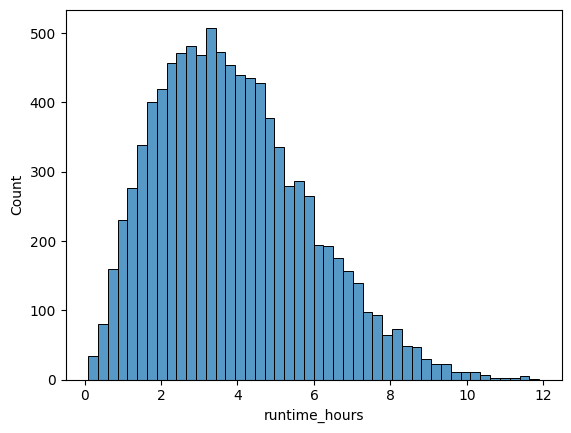

In [17]:
 plot_runtime_hours_distribution(df)

In [18]:
### MANUALLY GRADED TASK
def plot_output_quality_distribution(df):
    """
    Plot the `output_quality` distribution.
    """

    ### BEGIN SOLUTION
    sns.barplot(df["output_quality"].value_counts())
    ### END SOLUTION

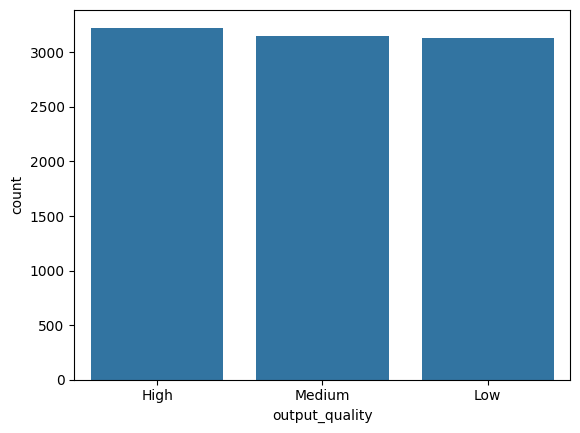

In [19]:
plot_output_quality_distribution(df)

In [20]:
### MANUALLY GRADED TASK
def plot_relationship_between_lubrication_index_and_machine_health_index(df):
    """
    Plot the relationship between `lubrication_index` and `machine_health_index`.
    """

    ### BEGIN SOLUTION
    sns.scatterplot(df, x="lubrication_index", y="machine_health_index")
    ### END SOLUTION

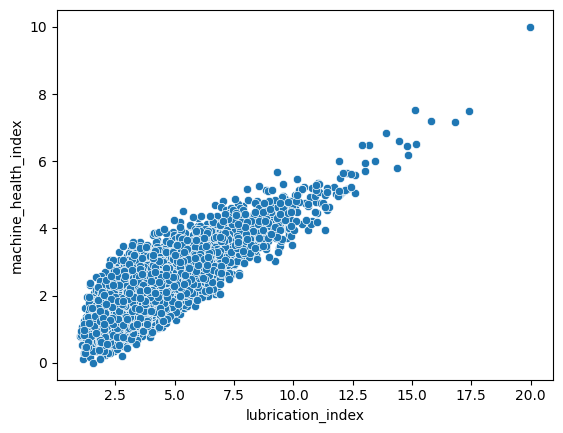

In [21]:
plot_relationship_between_lubrication_index_and_machine_health_index(df)

In [22]:
### MANUALLY GRADED TASK
def plot_lubrication_index_distribution_per_operation_mode(df):
    """
    Plot the `lubrication_index` distribution per `operation_mode`.
    """

    ### BEGIN SOLUTION
    sns.boxplot(df, x="operation_mode", y="lubrication_index")
    ### END SOLUTION

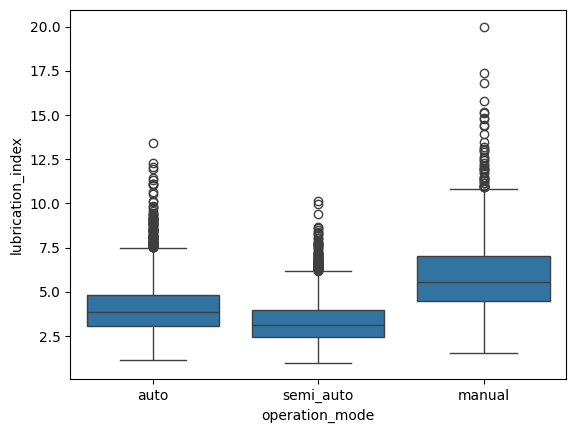

In [23]:
plot_lubrication_index_distribution_per_operation_mode(df)

In [24]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_device_info(df):
    """
    Encode the `device_info` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["device_info"], inplace=True)
    ### END SOLUTION
    
    return df

In [25]:
df = encode_or_drop_device_info(df)

In [26]:
### TEST
test_func(encode_or_drop_device_info, "6d76980648ddc027e729a71871a614bc4210520ea82bc8131c0f2a199a1e7de8")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_device_info():
    # df.to_csv("encode_or_drop_device_info.csv")
    expected_df = pd.read_csv("encode_or_drop_device_info.csv", index_col=0)
    initial_df = pd.read_csv("manufacturing.csv")
    actual_df = encode_or_drop_device_info(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_device_info()
### END HIDDEN TESTS

✔ Test passed!


In [27]:
### AUTOMATICALLY GRADED TASK
def parse_machine_temperature_and_machine_vibration_from_sensor_packet(df):
    """
    In the `sensor_packet` column, `T` stands for `machine_temperature` and `V` for `machine_vibration`.
    Parse the values for the `machine_temperature` from the `sensor_packet` column and add them as a new column named `machine_temperature`.
    Parse the values for the `machine_vibration` from the `sensor_packet` column and add them as a new column named `machine_vibration`.
    Then, remove the `sensor_packet` column from the dataset.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["machine_temperature"] = df["sensor_packet"].apply(lambda value: float(value.split(" ")[0][2:]) if not pd.isna(value) else value)
    df["machine_vibration"] = df["sensor_packet"].apply(lambda value: float(value.split(" ")[1][2:]) if not pd.isna(value) else value)
    df.drop(columns=["sensor_packet"], inplace=True)
    ### END SOLUTION
    
    return df

In [28]:
df = parse_machine_temperature_and_machine_vibration_from_sensor_packet(df)

In [29]:
### TEST
test_func(parse_machine_temperature_and_machine_vibration_from_sensor_packet, "4479131b82ca742029761c424e48705b47ae5bd39d9b5ab85c23254f3e8b370d")
### BEGIN HIDDEN TESTS
def test_parse_machine_temperature_and_machine_vibration_from_sensor_packet():
    # df.to_csv("parse_machine_temperature_and_machine_vibration_from_sensor_packet.csv")
    expected_df = pd.read_csv("parse_machine_temperature_and_machine_vibration_from_sensor_packet.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_device_info.csv", index_col=0)
    actual_df = parse_machine_temperature_and_machine_vibration_from_sensor_packet(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_parse_machine_temperature_and_machine_vibration_from_sensor_packet()
### END HIDDEN TESTS

✔ Test passed!


In [30]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_operation_mode(df):
    """
    Encode the `operation_mode` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df = pd.concat([df, pd.get_dummies(df["operation_mode"])], axis=1)
    df.drop(columns=["operation_mode"], inplace=True)
    ### END SOLUTION
    
    return df

In [31]:
df = encode_or_drop_operation_mode(df)

In [32]:
### TEST
test_func(encode_or_drop_operation_mode, "6d9610da4105b6fab7d2d4c1a15b27007a06d36ebfa2d10dd26769553ad5e82f")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_operation_mode():
    # df.to_csv("encode_or_drop_operation_mode.csv")
    expected_df = pd.read_csv("encode_or_drop_operation_mode.csv", index_col=0)
    initial_df = pd.read_csv("parse_machine_temperature_and_machine_vibration_from_sensor_packet.csv", index_col=0)
    actual_df = encode_or_drop_operation_mode(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_operation_mode()
### END HIDDEN TESTS

✔ Test passed!


In [33]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_plant_section(df):
    """
    Encode the `plant_section` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df = pd.concat([df, pd.get_dummies(df["plant_section"])], axis=1)
    df.drop(columns=["plant_section"], inplace=True)
    ### END SOLUTION
    
    return df

In [34]:
df = encode_or_drop_plant_section(df)

In [35]:
### TEST
test_func(encode_or_drop_plant_section, "f576d774ff5303a4b945556538ecdfea7c6d5e1d2af59c1cd472a923f24ded41")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_plant_section():
    # df.to_csv("encode_or_drop_plant_section.csv")
    expected_df = pd.read_csv("encode_or_drop_plant_section.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_operation_mode.csv", index_col=0)
    actual_df = encode_or_drop_plant_section(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_plant_section()
### END HIDDEN TESTS

✔ Test passed!


In [36]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_product_family(df):
    """
    Encode the `product_family` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["product_family"], inplace=True)
    ### END SOLUTION
    
    return df

In [37]:
df = encode_or_drop_product_family(df)

In [38]:
### TEST
test_func(encode_or_drop_product_family, "309b0272755d5140948f8944a8326ea15b4221c70ad0f44f6739103ca0e91aa4")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_product_family():
    # df.to_csv("encode_or_drop_product_family.csv")
    expected_df = pd.read_csv("encode_or_drop_product_family.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_plant_section.csv", index_col=0)
    actual_df = encode_or_drop_product_family(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_product_family()
### END HIDDEN TESTS

✔ Test passed!


In [39]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_production_stage(df):
    """
    Encode the `production_stage` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["production_stage"] = df["production_stage"].map({"Init": 0, "Processing": 1, "Assembly": 2, "Final": 3})
    ### END SOLUTION
    
    return df

In [40]:
df = encode_or_drop_production_stage(df)

In [41]:
### TEST
test_func(encode_or_drop_production_stage, "d6e02f5a657fe34bed174a128439eeaed278bd204fcdf1affc87fc4070581942")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_production_stage():
    # df.to_csv("encode_or_drop_production_stage.csv")
    expected_df = pd.read_csv("encode_or_drop_production_stage.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_product_family.csv", index_col=0)
    actual_df = encode_or_drop_production_stage(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_production_stage()
### END HIDDEN TESTS

✔ Test passed!


In [42]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_fault_severity(df):
    """
    Encode the `fault_severity` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["fault_severity"] = df["fault_severity"].map({"No Fault": 0, "Low": 1, "Medium": 2, "High": 3})
    ### END SOLUTION
    
    return df

In [43]:
df = encode_or_drop_fault_severity(df)

In [44]:
### TEST
test_func(encode_or_drop_fault_severity, "2263a9ef0c09ad60c24586dc45b5006d2daf4b453cd661ad7b0c4d2edf2897d4")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_fault_severity():
    # df.to_csv("encode_or_drop_fault_severity.csv")
    expected_df = pd.read_csv("encode_or_drop_fault_severity.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_production_stage.csv", index_col=0)
    actual_df = encode_or_drop_fault_severity(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_fault_severity()
### END HIDDEN TESTS

✔ Test passed!


In [45]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_certification_level(df):
    """
    Encode the `certification_level` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.drop(columns=["certification_level"], inplace=True)
    ### END SOLUTION
    
    return df

In [46]:
df = encode_or_drop_certification_level(df)

In [47]:
### TEST
test_func(encode_or_drop_certification_level, "e2ac8549f3ed16dff5da2b2e34b3631759f96e8af3a3534e92847d2adb9fa292")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_certification_level():
    # df.to_csv("encode_or_drop_certification_level.csv")
    expected_df = pd.read_csv("encode_or_drop_certification_level.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_fault_severity.csv", index_col=0)
    actual_df = encode_or_drop_certification_level(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_certification_level()
### END HIDDEN TESTS

✔ Test passed!


In [48]:
### AUTOMATICALLY GRADED TASK
def encode_or_drop_output_quality(df):
    """
    Encode the `output_quality` variable or remove it from the dataset.

    Note: If you plan to perform one-hot encoding, use the `pd.get_dummies` function and
    append the new columns to the dataset. Also, remove the original column.
    
    Return the dataset as `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df["output_quality"] = df["output_quality"].map({"Low": 0, "Medium": 1, "High": 2})
    ### END SOLUTION
    
    return df

In [49]:
df = encode_or_drop_output_quality(df)

In [50]:
### TEST
test_func(encode_or_drop_output_quality, "10bb335981282eb5782c66c6e5fe5e25e358d67bc3fd66d068689d1877d993aa")
### BEGIN HIDDEN TESTS
def test_encode_or_drop_output_quality():
    # df.to_csv("encode_or_drop_output_quality.csv")
    expected_df = pd.read_csv("encode_or_drop_output_quality.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_certification_level.csv", index_col=0)
    actual_df = encode_or_drop_output_quality(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_encode_or_drop_output_quality()
### END HIDDEN TESTS

✔ Test passed!


In [51]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_runtime_hours(df):
    """
    Impute or remove the missing values from the `runtime_hours` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["runtime_hours"]] = simple_imputer.fit_transform(df[["runtime_hours"]])
    ### END SOLUTION
    
    return df

In [52]:
df = handle_missing_values_in_runtime_hours(df)

In [53]:
### TEST
test_func(handle_missing_values_in_runtime_hours, "ee677dda5c4e6103e4662c27a5bab37c683add245a48ecb22b0bd408bbe7d6d1")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_runtime_hours():
    # df.to_csv("handle_missing_values_in_runtime_hours.csv")
    expected_df = pd.read_csv("handle_missing_values_in_runtime_hours.csv", index_col=0)
    initial_df = pd.read_csv("encode_or_drop_output_quality.csv", index_col=0)
    actual_df = handle_missing_values_in_runtime_hours(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_runtime_hours()
### END HIDDEN TESTS

✔ Test passed!


In [54]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_machine_temperature(df):
    """
    Impute or remove the missing values from the `machine_temperature` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["machine_temperature"]] = simple_imputer.fit_transform(df[["machine_temperature"]])
    ### END SOLUTION
    
    return df

In [55]:
df = handle_missing_values_in_machine_temperature(df)

In [56]:
### TEST
test_func(handle_missing_values_in_machine_temperature, "65283358b02a5b734d6d74d7cd841e49bf00febd661b72eb5be01b70d1f1ca49")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_machine_temperature():
    # df.to_csv("handle_missing_values_in_machine_temperature.csv")
    expected_df = pd.read_csv("handle_missing_values_in_machine_temperature.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_runtime_hours.csv", index_col=0)
    actual_df = handle_missing_values_in_machine_temperature(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_machine_temperature()
### END HIDDEN TESTS

✔ Test passed!


In [57]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_machine_vibration(df):
    """
    Impute or remove the missing values from the `machine_vibration` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    simple_imputer = SimpleImputer(strategy="median")
    df[["machine_vibration"]] = simple_imputer.fit_transform(df[["machine_vibration"]])
    ### END SOLUTION
    
    return df

In [58]:
df = handle_missing_values_in_machine_vibration(df)

In [59]:
### TEST
test_func(handle_missing_values_in_machine_vibration, "65283358b02a5b734d6d74d7cd841e49bf00febd661b72eb5be01b70d1f1ca49")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_machine_vibration():
    # df.to_csv("handle_missing_values_in_machine_vibration.csv")
    expected_df = pd.read_csv("handle_missing_values_in_machine_vibration.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_machine_temperature.csv", index_col=0)
    actual_df = handle_missing_values_in_machine_vibration(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_machine_vibration()
### END HIDDEN TESTS

✔ Test passed!


In [60]:
### MANUALLY GRADED TASK
def handle_missing_values_in_lubrication_index_and_machine_health_index(df):
    """
    Impute or remove the missing values from the `lubrication_index` and `machine_health_index` columns.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    iterative_imputer = IterativeImputer()
    df[["lubrication_index", "machine_health_index"]] = iterative_imputer.fit_transform(df[["lubrication_index", "machine_health_index"]])
    ### END SOLUTION
    
    return df

In [61]:
df = handle_missing_values_in_lubrication_index_and_machine_health_index(df)
# df.to_csv("handle_missing_values_in_lubrication_index_and_machine_health_index.csv")

In [62]:
### MANUALLY GRADED TASK
def handle_missing_values_in_fault_severity(df):
    """
    Impute the missing values in the `fault_severity` column using `KNNImputer` with 3 neighbors.
    Use `lubrication_index` and `machine_health_index` for imputation.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    knn_imputer = KNNImputer(n_neighbors=3)
    df[["fault_severity", "lubrication_index", "machine_health_index"]] = knn_imputer.fit_transform(df[["fault_severity", "lubrication_index", "machine_health_index"]])
    df["fault_severity"] = df["fault_severity"].round()
    ### END SOLUTION
    
    return df

In [63]:
df = handle_missing_values_in_fault_severity(df)
# df.to_csv("handle_missing_values_in_fault_severity.csv")

In [65]:
### AUTOMATICALLY GRADED TASK
def handle_missing_values_in_output_quality(df):
    """
    Impute or remove the missing values from the `output_quality` column.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the dataset as a `pd.DataFrame`.
    """

    ### BEGIN SOLUTION
    df.dropna(subset=["output_quality"], axis=0, inplace=True)
    ### END SOLUTION
    
    return df

In [66]:
df = handle_missing_values_in_output_quality(df)

In [67]:
### TEST
test_func(handle_missing_values_in_output_quality, "3011e8b0b698e6fb12ea18da936243d9af35f8392761259f55079d97249162b2")
### BEGIN HIDDEN TESTS
def test_handle_missing_values_in_output_quality():
    # df.to_csv("handle_missing_values_in_output_quality.csv")
    expected_df = pd.read_csv("handle_missing_values_in_output_quality.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_fault_severity.csv", index_col=0)
    actual_df = handle_missing_values_in_output_quality(initial_df)
    pd.testing.assert_frame_equal(expected_df, actual_df)
test_handle_missing_values_in_output_quality()
### END HIDDEN TESTS

✔ Test passed!


In [68]:
### AUTOMATICALLY GRADED TASK
def split_dataset_into_train_and_test(df):
    """
    Split the dataset into features `X` and target `y`, where the target is `output_quality`.
    Then, divide `X` and `y` into training and test sets using an 85:15 ratio.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.
    
    Return `train_X`, `test_X`, `train_y`, and `test_y`.
    """

    ### BEGIN SOLUTION
    X, y = df.drop(columns=["output_quality"]), df["output_quality"]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)
    ### END SOLUTION
    
    return train_X, test_X, train_y, test_y

In [69]:
train_X, test_X, train_y, test_y = split_dataset_into_train_and_test(df)

In [70]:
### TEST
test_partition(
    split_dataset_into_train_and_test,
    "b25c2154a2e46df2070da8d73a141582d55b4a5c9ed839a04c3b311b60b4fba3",
    "aec0c1adb3ee4120139b4f5a982978c97d5705bc5fc7e76bf10a15269836ad31",
    "4a5681c6f8c8612d3150957ba265b0f444c10bbc20b92ae0990cbd6507690a95",
    "c407cdf039e14bf9bf999bec2bccea33e626f00313e10a44b5b4e6d6cd9ca2d4",
)
### BEGIN HIDDEN TESTS
def test_split_dataset_into_train_and_test():
    # train_X.to_csv("partition_train_X.csv")
    # test_X.to_csv("partition_test_X.csv")
    # train_y.to_csv("partition_train_y.csv")
    # test_y.to_csv("partition_test_y.csv")
    expected_train_X = pd.read_csv("partition_train_X.csv", index_col=0)
    expected_test_X = pd.read_csv("partition_test_X.csv", index_col=0)
    expected_train_y = pd.read_csv("partition_train_y.csv", index_col=0)
    expected_test_y = pd.read_csv("partition_test_y.csv", index_col=0)
    initial_df = pd.read_csv("handle_missing_values_in_output_quality.csv", index_col=0)
    actual_train_X, actual_test_X, actual_train_y, actual_test_y = split_dataset_into_train_and_test(initial_df)
    pd.testing.assert_frame_equal(expected_train_X, actual_train_X)
    pd.testing.assert_frame_equal(expected_test_X, actual_test_X)
    pd.testing.assert_series_equal(expected_train_y["output_quality"], actual_train_y)
    pd.testing.assert_series_equal(expected_test_y["output_quality"], actual_test_y)
test_split_dataset_into_train_and_test()
### END HIDDEN TESTS

✔ Test passed!


In [71]:
### AUTOMATICALLY GRADED TASK
def normalize_features(train_X, test_X):
    """
    Normalize the features in `train_X` and `test_X`.

    Return `train_X` and `test_X`.
    """

    ### BEGIN SOLUTION
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train_X)
    test_X = scaler.transform(test_X)
    ### END SOLUTION
    
    return train_X, test_X

In [72]:
train_X, test_X = normalize_features(train_X, test_X)

In [73]:
### TEST
test_normalize(
    normalize_features,
    "e778e1018f88e87f6e987c48e826be22c6331340227e3ab24b23a688502e4b30",
    "55fb45b7e95d247c3baab11369c8c9cda102c3e9eb01e9b162a8d0abfcbfe67f",
)
### BEGIN HIDDEN TESTS
def test_normalize_features():
    # pd.DataFrame(train_X).to_csv("normalize_train_X.csv")
    # pd.DataFrame(test_X).to_csv("normalize_test_X.csv")
    expected_train_X = pd.read_csv("normalize_train_X.csv", index_col=0)
    expected_test_X = pd.read_csv("normalize_test_X.csv", index_col=0)
    initial_train_X = pd.read_csv("partition_train_X.csv", index_col=0)
    initial_test_X = pd.read_csv("partition_test_X.csv", index_col=0)
    actual_train_X, actual_test_X = normalize_features(initial_train_X, initial_test_X)
    np.testing.assert_almost_equal(expected_train_X, actual_train_X, decimal=4)
    np.testing.assert_almost_equal(expected_test_X, actual_test_X, decimal=4)
test_normalize_features()
### END HIDDEN TESTS

✔ Test passed!


In [74]:
### AUTOMATICALLY GRADED TASK
def fit_model(train_X, train_y):
    """
    Fit a bagging tree-based model to predict `y` using `X` with 175 estimators and a maximum depth of 12.

    Use `random_state=RANDOM_STATE` to ensure reproducibility.

    Return the fitted model.
    """

    ### BEGIN SOLUTION
    model = RandomForestClassifier(
        n_estimators=175,
        max_depth=12,
        random_state=RANDOM_STATE,
    ).fit(train_X, train_y)
    ### END SOLUTION
    
    return model

In [75]:
model = fit_model(train_X, train_y)
pred_y = model.predict(test_X)

In [76]:
### TEST
test_model(fit_model, "54d9400191673f7556ec72ce91eebbc703da39f740b96309dbca3d4c93fc4a4e")
### BEGIN HIDDEN TESTS
def test_fit_model():
    # pd.DataFrame(pred_y, columns=["output_quality"]).to_csv("pred_y.csv")
    expected_pred_y = pd.read_csv("pred_y.csv", index_col=0)["output_quality"]
    initial_train_X = pd.read_csv("normalize_train_X.csv", index_col=0)
    initial_test_X = pd.read_csv("normalize_test_X.csv", index_col=0)
    initial_train_y = pd.read_csv("partition_train_y.csv", index_col=0)["output_quality"]
    initial_test_y = pd.read_csv("partition_test_y.csv", index_col=0)["output_quality"]
    actual_model = fit_model(initial_train_X, initial_train_y)
    actual_pred_y = actual_model.predict(initial_test_X)
    np.testing.assert_array_equal(expected_pred_y, actual_pred_y)
test_fit_model()
### END HIDDEN TESTS

✔ Test passed!


In [77]:
### AUTOMATICALLY GRADED TASK
def evaluate_model(test_y, pred_y):
    """
    Evaluate the model using precision, recall, and F1-score, with a weighted average.

    Return `precision`, `recall`, and `f1`.
    """
    
    ### BEGIN SOLUTION
    precision = precision_score(test_y, pred_y, average="weighted")
    recall = recall_score(test_y, pred_y, average="weighted")
    f1 = f1_score(test_y, pred_y, average="weighted")
    ### END SOLUTION

    return round(precision, 2), round(recall, 2), round(f1, 2)

In [78]:
precision, recall, f1 = evaluate_model(test_y, pred_y)

In [79]:
### TEST
test_evaluation(precision, recall, f1)
### BEGIN HIDDEN TESTS
def test_precision_recall_f1():
    initial_test_y = pd.read_csv("partition_test_y.csv", index_col=0)["output_quality"]
    initial_pred_y = pd.read_csv("pred_y.csv", index_col=0)["output_quality"]
    actual_precision, actual_recall, actual_f1 = evaluate_model(initial_test_y, initial_pred_y)
    assert actual_precision > 0.65
    assert actual_recall > 0.65
    assert actual_f1 > 0.65
test_precision_recall_f1()
### END HIDDEN TESTS

✔ Test passed!
